<a href="https://colab.research.google.com/github/davidcpage/seqdist/blob/master/notebooks/01_CTC_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# default_exp ctc

# CTC loss

> A simple and somewhat efficient implementation of the standard [CTC loss function](http://www.cs.toronto.edu/~graves/icml_2006.pdf) using pytorch and cupy.

In [ ]:
!nvidia-smi

Fri May 29 09:22:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    82W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
#export
import numpy as np
import cupy as cp
import torch
import torch.nn as nn
from collections import namedtuple
from seqdist.utils import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Preliminaries

Generate a test example:

In [ ]:
#export
def generate_sample_inputs(T_min, T_max, N, C, L_min, L_max, device=device):
    """
    Args:
        T_min, T_max: bounds on number of time steps
        N: batch size
        C: alphabet size (including blank)
        L_min, L_max: bounds on target length
    """
    logits = torch.randn(T_max, N, C, device=device, requires_grad=True)
    targets = torch.randint(1, C, (N, L_max), dtype=torch.long, device=device)
    input_lengths = torch.randint(T_min, T_max+1, (N,), dtype=torch.long, device=device)
    target_lengths = torch.randint(L_min, L_max+1, (N,), dtype=torch.long, device=device)
    return logits, targets, input_lengths, target_lengths

NB: The pytorch (1.5.0) CTC loss has inconsistent behaviour for input logits which haven't been through log_softmax. The standard pytorch backend produces an incorrect gradient in this case and the standard and Cudnn backends return different results as demonstrated here:

In [ ]:
logits, targets, input_lengths, target_lengths = generate_sample_inputs(50, 50, 8, 20, 10, 30)
targets_cudnn = torch.cat([t[:l] for t,l in zip(targets, target_lengths)]).to(torch.int).cpu() #triggers the cudnn backend 

print('log_softmax')
print('torch:  {:.4f}'.format(nn.functional.ctc_loss(logits.log_softmax(2), targets, input_lengths, target_lengths)))
print('cudnn: {:.4f}\n'.format(nn.functional.ctc_loss(logits.log_softmax(2), targets_cudnn, input_lengths, target_lengths)))

print('no log_softmax')
print('torch:  {:.4f}'.format(nn.functional.ctc_loss(logits, targets, input_lengths, target_lengths)))
print('cudnn:  {:.4f}'.format(nn.functional.ctc_loss(logits, targets_cudnn, input_lengths, target_lengths)))

log_softmax
torch:  6.0089
cudnn:  6.0089

no log_softmax
torch:  -2.8939
cudnn:  6.0089


To avoid the issue, let's define all our CTC losses to accept logits and apply log_softmax internally (similarly to what the Cudnn loss does):

In [ ]:
#export
def loss_pytorch(logits, targets, input_lengths, target_lengths, blank=0, reduction='mean', zero_infinity=False):
    log_probs = logits.log_softmax(2)
    return nn.functional.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank, reduction, zero_infinity)

In [ ]:
sample_inputs = logits, targets, input_lengths, target_lengths = generate_sample_inputs(T_min=450, T_max=500, N=128, C=20, L_min=80, L_max=100)
loss_pytorch(*sample_inputs).item()

12.637479782104492

In [ ]:
report(benchmark_fwd_bwd(loss_pytorch, *sample_inputs))

fwd: 4.70ms (3.96-5.30ms)
bwd: 9.80ms (8.59-10.84ms)
tot: 14.50ms (13.15-15.57ms)


## Loss implementations

### 1. Basic pytorch

Here's a straightforward implementation in pytorch. As is standard, we're working in logspace for numerical stability. In the interests of clarity, we've encapsulated the logspace arithmetic into an object: Log.


In [ ]:
#export
semiring = namedtuple('semiring', ('zero', 'one', 'mul', 'sum', 'dsum'))
neginf = -1e38
Log = semiring(zero=neginf, one=0., mul=torch.add, sum=torch.logsumexp, dsum=torch.softmax)

def interleave_blanks(targets, blank_idx: int):
    N, L = targets.shape
    interleaved = targets.new_full((N, 2*L+1), blank_idx)
    interleaved[:, 1::2] = targets
    return interleaved

def prepare_inputs(scores, targets, input_lengths, target_lengths):
    states = interleave_blanks(targets, blank_idx=0)
    state_scores = torch.gather(scores, 2, states.expand(scores.size(0), -1, -1))
    repeat_mask = torch.nn.functional.pad(states[:, 2:] == states[:, :-2], (2, 0), value=0.)
    final_states = torch.stack([target_lengths*2-1, target_lengths*2], 1)  
    return state_scores, repeat_mask, final_states, input_lengths

def _logz_fwd(state_scores, repeat_mask, final_states, input_lengths, S:semiring=Log):
    T, N, Lp = state_scores.shape
    zeros = state_scores.new_full((N, Lp), S.zero)
    a = state_scores.new_full((N, Lp+2), S.zero)
    a[:, 2] = S.one
    alpha = torch.empty_like(state_scores)
    for t in range(0, T):
        alpha[t] = a[:, 2:] = S.mul(state_scores[t], S.sum(
            torch.stack([a[:, 2:], a[:, 1:-1], torch.where(repeat_mask, zeros, a[:, :-2])]), dim=0))
    return S.sum(alpha[input_lengths-1, torch.arange(N)].gather(1, final_states), dim=1)

def loss_basic(logits, targets, input_lengths, target_lengths):
    log_probs = logits.log_softmax(2)
    logz = _logz_fwd(*prepare_inputs(log_probs, targets, input_lengths, target_lengths))
    return -(logz / target_lengths).mean()

It works:

In [ ]:
compare_fwd_bwd(float64(loss_pytorch), float64(loss_basic), *sample_inputs);

fwd diff: 0.00e+00
bwd diff: 4.55e-13


In [ ]:
compare_fwd_bwd(loss_pytorch, loss_basic, *sample_inputs);

fwd diff: 0.00e+00
bwd diff: 1.10e-07


But it's very slow (roughly 100x slower than the native pytorch version):



In [ ]:
report(benchmark_fwd_bwd(loss_basic, *sample_inputs))

fwd: 212.33ms (196.86-240.76ms)
bwd: 1057.07ms (1056.57-1057.61ms)
tot: 1269.41ms (1253.75-1297.93ms)


### 2. Pytorch with grad

Our aim here is twofold. First we want to compute grads explicitly rather than relying on pytorch autograd. It's a good idea to do this in pytorch to iron out bugs before dropping to cuda. 

Secondly we want to restructure the code ready to call a cuda implementation of the inner loop. This requires an outer function (fwd_bwd) to setup result arrays which gets filled in by the inner loop (_fwd_bwd_py or later on _fwd_bwd_cupy.) 

In [ ]:
#export
def fwd_bwd(state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl, S:semiring=Log):
    T, N, Lp = state_scores.shape
    alpha, beta = [state_scores.new_full((T+1, N, Lp), S.zero) for _ in range(2)]
    alpha[0, :, 0] = S.one  
    beta[input_lengths, torch.arange(N)] = state_scores.new_full((N, Lp), S.zero).scatter_(1, final_states, S.one)
    alpha_T = fwd_bwd_impl(alpha, beta, state_scores, repeat_mask, input_lengths, S)
    logz = S.sum(alpha_T.gather(1, final_states), dim=1)
    return alpha, beta, logz 

def _fwd_bwd_py(alpha, beta, state_scores, repeat_mask, input_lengths, S:semiring=Log):
    T, N, Lp = state_scores.shape
    zeros = alpha.new_full((1,), S.zero)
    #fwd
    a = torch.cat([alpha.new_full((N, 2), S.zero), alpha[0]], 1)
    for t in range(0, T):
        a[:, 2:] = S.mul(state_scores[t], S.sum(torch.stack([a[:, 2:], a[:, 1:-1], torch.where(repeat_mask, zeros, a[:, :-2])]), dim=0)) 
        alpha[t+1] = a[:, 2:]
    #bwd
    b = alpha.new_full((N, Lp+2), S.zero)
    repeat_mask = torch.cat([repeat_mask[:, 2:], repeat_mask[:, :2]], 1)
    for t in range(T, 0, -1):
        b[:, :-2] = S.mul(beta[t], state_scores[t-1])
        b[:, :-2] = S.sum(torch.stack([b[:, :-2], b[:, 1:-1], torch.where(repeat_mask, zeros, b[:, 2:])]), dim=0)
        beta[t-1, t <= input_lengths] = b[t <= input_lengths, :-2]

    return alpha[input_lengths, torch.arange(N)]

def masked_grad(grad, input_lengths):
    input_mask = (torch.arange(grad.size(0), device=grad.device)[:, None] < input_lengths)
    return torch.where(input_mask, grad, grad.new_zeros((1,))).unsqueeze(2)    

class _Logz(torch.autograd.Function):
    @staticmethod
    def forward(ctx, state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl):
        alpha, beta, logz = fwd_bwd(state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl, Log)
        ctx.save_for_backward(alpha, beta, input_lengths)
        return logz

    @staticmethod
    def backward(ctx, grad):
        alpha, beta, input_lengths = ctx.saved_tensors
        g = torch.softmax(alpha[1:] + beta[1:], dim=2) * masked_grad(grad.expand(alpha.size(0)-1, -1), input_lengths)
        return g, None, None, None, None

def loss_py(logits, targets, input_lengths, target_lengths):
    logz = _Logz.apply(*prepare_inputs(logits.log_softmax(2), targets, input_lengths, target_lengths), _fwd_bwd_py)
    return - (logz / target_lengths).mean()

In [ ]:
fwds, bwds = compare_fwd_bwd(float64(loss_pytorch), float64(loss_py, *sample_inputs)

fwd diff: 0.00e+00
bwd diff: 4.55e-13


In [ ]:
fwds, bwds = compare_fwd_bwd(loss_pytorch, loss_py, *sample_inputs)

fwd diff: 0.00e+00
bwd diff: 1.00e-07


In [ ]:
report(benchmark_fwd_bwd(loss_py, *sample_inputs))

fwd: 534.67ms (504.20-596.38ms)
bwd: 6.62ms (6.58-6.78ms)
tot: 541.29ms (510.89-602.96ms)


### 3. Cupy

In [ ]:
%%writefile cuda/ctc.cu
__device__ __forceinline__ FLOAT max3(FLOAT a, FLOAT a1, FLOAT a2) {
    FLOAT maxa = a > a1 ? a : a1; 
    return maxa > a2 ? maxa : a2;
}

__device__ __forceinline__ FLOAT logsumexp3(FLOAT a, FLOAT a1, FLOAT a2) {
    FLOAT maxa = max3(a, a1, a2); 
    return maxa + log(exp(a-maxa) + exp(a1-maxa) + exp(a2-maxa));
}

__device__ __forceinline__ FLOAT sum3(FLOAT a, FLOAT a1, FLOAT a2) {return a + a1 + a2;}
__device__ __forceinline__ FLOAT add(FLOAT a, FLOAT b) {return a + b;}
__device__ __forceinline__ FLOAT mul(FLOAT a, FLOAT b) {return a * b;}

extern "C" __global__ void fwd_bwd_logspace(
    FLOAT* __restrict__ alpha_T, 
    FLOAT* __restrict__ alpha, FLOAT* __restrict__ beta,  
    const FLOAT* __restrict__ scores,  const bool* __restrict__ repeat_mask, 
    const long* __restrict__ lengths,
    int N, int L
) {
    int bx = blockIdx.x, tx = threadIdx.x;
    if (tx >= L) return;
    extern __shared__ FLOAT smem[];
    int T = (int) lengths[bx];
    if (blockIdx.y == 0) {
        FLOAT a = ZERO, a1 = ZERO, a2 = ZERO;
        a = alpha[bx * L + tx];
        for (int t = 0; t < T; t++) {
            FLOAT *buf = smem + (t % 2) * blockDim.x;
            buf[tx] = a; __syncthreads(); 
            if (tx > 0) a1 = buf[tx - 1];
            if (tx > 1) if (!repeat_mask[bx * L + tx]) a2 = buf[tx - 2];
            a = MUL(scores[(t * N + bx) * L + tx], SUM(a, a1, a2));
            alpha[((t + 1) * N + bx) * L + tx] = a;
        }
        alpha_T[bx*L + tx] = a;
    }
    else {
        FLOAT b = ZERO, b1 = ZERO, b2 = ZERO;
        b = beta[(T * N + bx) * L + tx];
        for (int t = T; t > 0; t--) {
            FLOAT *buf = smem + (t % 2) * blockDim.x;
            b = buf[tx] = MUL(b, scores[(((t - 1) * N + bx) * L) + tx]);
            __syncthreads(); 
            if (tx < L - 1) b1 = buf[tx+1];
            if (tx < L - 2) if (!repeat_mask[bx * L + tx + 2]) b2 = buf[tx + 2];
            b = beta[((t - 1) * N + bx) * L + tx] = SUM(b, b1, b2);
        }
    }
  }

Overwriting ctc.cu


In [ ]:
#export
cupy_funcs = {
    (torch.float32, Log): load_cupy_func('cuda/ctc.cu', 'fwd_bwd_logspace', FLOAT='float',  SUM='logsumexp3', MUL='add', ZERO='{:E}'.format(Log.zero)),
    (torch.float64, Log): load_cupy_func('cuda/ctc.cu', 'fwd_bwd_logspace', FLOAT='double', SUM='logsumexp3', MUL='add', ZERO='{:E}'.format(Log.zero)),
}

def _fwd_bwd_cupy(alpha, beta, state_scores, repeat_mask, input_lengths, S:semiring):
    T, N, Lp = state_scores.shape
    alpha_T = torch.empty_like(alpha[0])
    with cp.cuda.Device(state_scores.device.index):
        cupy_funcs[(state_scores.dtype, S)](grid=(N, 2, 1), block=(Lp, 1, 1), shared_mem=2*8*Lp,
               args=(alpha_T.data_ptr(), alpha.data_ptr(), beta.data_ptr(), state_scores.data_ptr(), repeat_mask.data_ptr(), 
                     input_lengths.data_ptr(), N, Lp))
    return alpha_T

def loss_cupy(logits, targets, input_lengths, target_lengths):
    logz = _Logz.apply(*prepare_inputs(logits.log_softmax(2), targets, input_lengths, target_lengths), _fwd_bwd_cupy)
    return - (logz / target_lengths).mean()

In [ ]:
fwds, bwds = compare_fwd_bwd(float64(loss_pytorch), float64(loss_cupy), *sample_inputs)

fwd diff: 0.00e+00
bwd diff: 4.55e-13


In [ ]:
fwds, bwds = compare_fwd_bwd(loss_pytorch, loss_cupy, *sample_inputs)

fwd diff: 0.00e+00
bwd diff: 1.00e-07


In [ ]:
report(benchmark_fwd_bwd(loss_cupy, *sample_inputs, nloops=100))

fwd: 6.51ms (5.94-8.54ms)
bwd: 5.18ms (4.83-6.53ms)
tot: 11.69ms (10.78-14.93ms)


## Viterbi alignments

In [ ]:
#export
def max_grad(x, dim=0): 
    return torch.zeros_like(x).scatter_(dim, x.argmax(dim, True), 1.0)

Max = semiring(zero=neginf, one=0., mul=torch.add, sum=(lambda x, dim=0: torch.max(x, dim=dim)[0]), dsum=max_grad)
cupy_funcs[(torch.float32, Max)] = load_cupy_func('cuda/ctc.cu', 'fwd_bwd_logspace', FLOAT='float',  SUM='max3', MUL='add', ZERO='{:E}'.format(Log.zero))
cupy_funcs[(torch.float64, Max)] = load_cupy_func('cuda/ctc.cu', 'fwd_bwd_logspace', FLOAT='double', SUM='max3', MUL='add', ZERO='{:E}'.format(Log.zero))

class _LogzViterbi(torch.autograd.Function):
    @staticmethod
    def forward(ctx, state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl):
        alpha, beta, logz = fwd_bwd(state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl, Max)
        ctx.save_for_backward(alpha, beta, input_lengths)
        return logz

    @staticmethod
    def backward(ctx, grad):
        alpha, beta, input_lengths = ctx.saved_tensors
        g = max_grad(alpha[1:] + beta[1:], dim=2) * masked_grad(grad.expand(alpha.size(0)-1, -1), input_lengths)
        return g, None, None, None, None

In [ ]:
#export
def viterbi_alignments(logits, targets, input_lengths, target_lengths):
    state_scores, repeat_mask, final_states, input_lengths = prepare_inputs(logits.log_softmax(2), targets, input_lengths, target_lengths)
    _LogzViterbi.apply(state_scores.detach_().requires_grad_(), repeat_mask, final_states, input_lengths, _fwd_bwd_cupy).sum().backward()
    return state_scores.grad

def soft_alignments(logits, targets, input_lengths, target_lengths, beta=1.0):
    state_scores, repeat_mask, final_states, input_lengths = prepare_inputs((logits*beta).log_softmax(2), targets, input_lengths, target_lengths)
    _Logz.apply(state_scores.detach_().requires_grad_(), repeat_mask, final_states, input_lengths, _fwd_bwd_cupy).sum().backward()
    return state_scores.grad

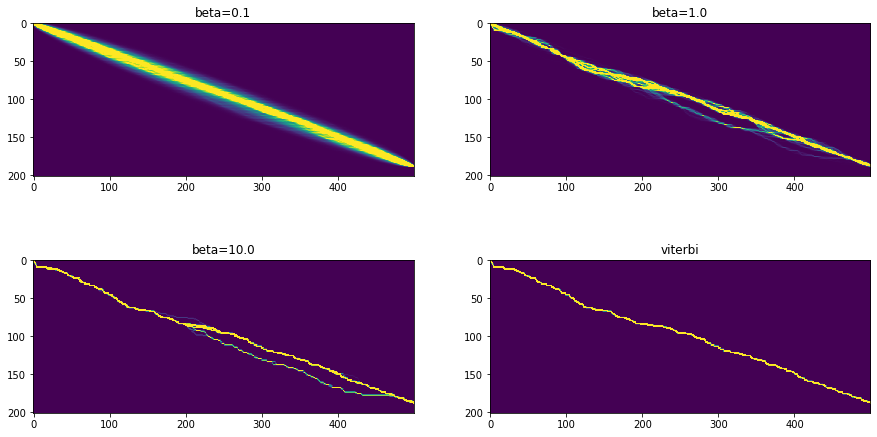

In [ ]:
import matplotlib.pyplot as plt
betas = [0.1, 1.0, 10.]
alignments = {'beta={:.1f}'.format(beta): to_np(soft_alignments(*sample_inputs, beta=beta)) for beta in betas}
alignments['viterbi'] = to_np(viterbi_alignments(*sample_inputs)
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
for (ax, (title, data)) in zip(np.array(axs).flatten(), alignments.items()):
    ax.imshow(data[:, 0].T, vmax=0.05);
    ax.set_title(title)  

## Direct loss calculation

Just for fun, here's a numerically unstable direct space calculation of the loss. We can try to fix the numerical instability (by pre-conditioning the transition probs and normalising the fwd_bwd state at regular intervals) if we need this at a later point.

In [ ]:
#export
Prob = semiring(zero=0., one=1., mul=torch.mul, sum=torch.sum, dsum=(lambda x, dim=0: torch.ones_like))
cupy_funcs[(torch.float64, Prob)] = load_cupy_func('cuda/ctc.cu', 'fwd_bwd_logspace', FLOAT='double', SUM='sum3', MUL='mul', ZERO='0.0')

class _LogzDirect(torch.autograd.Function):
    @staticmethod
    def forward(ctx, state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl):
        alpha, beta, z = fwd_bwd(state_scores, repeat_mask, final_states, input_lengths, fwd_bwd_impl, Prob)
        ctx.save_for_backward(alpha, beta, state_scores, input_lengths)
        return torch.log(z)

    @staticmethod
    def backward(ctx, grad):
        alpha, beta, state_probs, input_lengths = ctx.saved_tensors
        g = alpha[1:]*beta[1:]
        g = (g/state_probs)*masked_grad(grad.expand(alpha.size(0)-1, -1), input_lengths)/(g.sum(-1, keepdim=True)+1e-38) 
        return g, None, None, None, None

def loss_direct_cupy(logits, targets, input_lengths, target_lengths):
    logz = _LogzDirect.apply(*prepare_inputs(logits.softmax(2), targets, input_lengths, target_lengths), _fwd_bwd_cupy)
    return - (logz / target_lengths).mean()

Here's a mini test example which is short enough not to suffer from too much numerical instability (at least in double precision!)

In [ ]:
logits, targets, input_lengths, target_lengths = generate_sample_inputs(T_min=25, T_max=30, N=32, C=20, L_min=10, L_max=12)
fwds, bwds = compare_fwd_bwd(float64(loss_pytorch), float64(loss_direct_cupy), logits, targets, input_lengths, target_lengths)

fwd diff: 0.00e+00
bwd diff: 2.35e-08
